In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# 데이터 뜯어 보기

## 전체적 경향
- 본 데이터는 10분마다 측정한 데이터임
- 일일 누적 일사량이 144개마다 0으로 리셋되는 것을 보아 0시 0분부터 측정된 데이터라 유추할 수 있음
- X14, X16, X19는 train, test에서 모두 0 -> 삭제
- 기온 변수가 있는데 이는 대기 온도를 뜻하고 온도는 따뜻함과 차가움의 정도를 나타냄

## 일일 누적 일사량, 강수량
- 10분 간 데이터와 30분 간 누적 데이터를 추출

## 풍향
- 0부터 360까지라 각도를 나타냄. 사인 함수로 변형

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

np.random.seed(123)
random.seed(123)

train = pd.read_csv('/gdrive/My Drive/Data/train1.csv')
test = pd.read_csv('/gdrive/My Drive/Data/test1.csv')
test.index = test.id
sample_sub = pd.read_csv('/gdrive/My Drive/Data/sample_submission1.csv')
df = pd.concat([train,test],axis=0,sort=False)
df.drop(['X14','X16','X19'],axis=1, inplace=True)
for col in df.columns:
  col_type = df[col].dtypes
  if str(col_type)[:3] == 'int':
    df[col] = df[col].astype(np.int16)
  else:
    df[col] = df[col].astype(np.float32)

df_wind = pd.DataFrame()
df_sun_rain = pd.DataFrame()
df_wind[["X13_si","X15_si","X17_si","X25_si","X35_si"]] =  np.sin(2*np.pi*df[["X13","X15","X17","X25","X35"]]/360)
df_wind[["X13_cos","X15_cos","X17_cos","X25_cos","X35_cos"]] =  np.cos(2*np.pi*df[["X13","X15","X17","X25","X35"]]/360)
df.drop(["X13","X15","X17","X25","X35"],axis=1, inplace=True)
df_sun_rain[["X04","X10","X11","X21","X34","X36","X39"]] = df[["X04","X10","X11","X21","X34","X36","X39"]] - df[["X04","X10","X11","X21","X34","X36","X39"]].shift(1).fillna(0)
df_sun_rain.loc[np.arange(0,df.shape[0],144),["X04","X10","X11","X21","X34","X36","X39"]] = 0
df_sun_rain[["X04_diff","X10_diff","X11_diff","X21_diff","X34_diff","X36_diff","X39_diff"]] = df_sun_rain[["X04","X10","X11","X21","X34","X36","X39"]] + df_sun_rain[["X04","X10","X11","X21","X34","X36","X39"]].shift(1).fillna(0) + df_sun_rain[["X04","X10","X11","X21","X34","X36","X39"]].shift(2).fillna(0)
df_sun_rain.loc[np.arange(0,df.shape[0],144),["X04_diff","X10_diff","X11_diff","X21_diff","X34_diff","X36","X39"]] = 0
df_sun_rain.loc[np.arange(1,df.shape[0],144),["X04_diff","X10_diff","X11_diff","X21_diff","X34_diff","X36","X39"]] = 0
df.drop(["X04","X10","X11","X21","X34","X36","X39"],axis=1, inplace=True)
y_col = df.loc[:,"Y00":"Y18"].columns
df1 = df[y_col]
df.drop(y_col,axis=1,inplace=True)


minute = (df.id%144).astype(int)
hour= pd.Series((df.index%144/6).astype(int))
min_in_day = 24*6
hour_in_day = 24

minute_sin = np.sin(2*np.pi*minute/min_in_day) 
minute_cos = np.cos(2*np.pi*minute/min_in_day)
hour_sin  = np.sin(2*np.pi*hour/hour_in_day)
hour_cos  = np.cos(2*np.pi*hour/hour_in_day)

df_wind["minute_sin"], df_wind["minute_cos"],df_wind["hour_sin"],df_wind["hour_cos"] = minute_sin, minute_cos, hour_sin, hour_cos
df = pd.concat([df,df_sun_rain,df_wind,df1],axis=1,sort=False)
x_col = df.loc[:,"X00":"X39_diff"].columns
x_col1 = df.loc[:,"X13_si":"hour_cos"].columns
y_col = df.loc[:,"Y00":"Y17"].columns
train = df.iloc[:train.shape[0],:]
test = df.iloc[train.shape[0]:,:]

def standardization(df):
    dfmax = df.max()
    dfmin = df.min()
    norm = (df - dfmin) / (dfmax - dfmin)
    return norm, dfmin, dfmax
train_norm, train_min, train_max = standardization(train[x_col])
test_norm = (test[x_col] - train_min) / (train_max - train_min)

train1 = pd.concat([train["id"], train_norm, train[x_col1], train.loc[:,"minute_sin":"hour_cos"]], axis=1) 
test1  = pd.concat([test["id"] , test_norm, test[x_col1], test.loc[:,"minute_sin":"hour_cos"]] , axis=1)

In [87]:
train34 = train[["X00","X27","X05"]]
k = 1+0.00366*train34["X00"]
p = (train34["X05"]/train34["X27"])
train34["x"] = 18400*( k/ 273) * np.log10(p)
# train34["x"] = 0.03414*train34["X01"]*100/(273+train34["X00"])
# train34["x1"] = train34["X05"]- train34["X01"]
train34.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,X00,X27,X05,x
0,9.7,1008.700012,1009.299988,0.018025
1,9.3,1008.700012,1009.299988,0.017999
2,9.4,1008.599976,1009.200012,0.018009
3,9.4,1008.700012,1009.200012,0.015004
4,9.2,1008.700012,1009.200012,0.014994


In [88]:
train34.describe()

,X00,X27,X05,x
count,4752.000000,4752.000000,4752.000000,4752.000000
mean,20.227880,1007.554382,1008.334778,0.024244
std,4.707582,3.446481,3.395032,0.014871
min,8.300000,997.200012,997.200012,-0.031135
25%,16.900000,1005.500000,1006.500000,0.015652
50%,19.900000,1007.700012,1008.500000,0.024673
75%,24.100000,1010.200012,1010.799988,0.031905
max,30.900000,1015.400024,1016.799988,0.095818


In [4]:
train1.describe()

,id,X00,X01,X02,X03,X05,X06,X07,X08,X09,X12,X18,X20,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X37,X38,X04,X10,X11,X21,X34,X36,X39,X04_diff,X10_diff,X11_diff,X21_diff,X34_diff,X36_diff,X39_diff,X13_si,X15_si,X17_si,X25_si,X35_si,X13_cos,X15_cos,X17_cos,X25_cos,X35_cos,minute_sin,minute_cos,hour_sin,hour_cos,minute_sin,minute_cos,hour_sin,hour_cos
count,4752.00000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4.752000e+03,4.752000e+03,4.752000e+03,4.752000e+03,4.752000e+03,4.752000e+03,4.752000e+03,4.752000e+03
mean,2375.50000,0.527784,0.568899,0.148017,0.250544,0.568055,0.565030,0.476686,0.568830,0.557336,0.635703,0.154771,0.662135,0.568561,0.579132,0.164176,0.201455,0.568947,0.514368,0.575749,0.604732,0.523257,0.529671,0.573192,0.602972,0.523780,0.005317,0.007155,0.079748,0.005051,0.054420,0.003300,0.005724,0.008776,0.008586,0.156398,0.006912,0.135322,0.004635,0.007207,-0.070118,-0.071943,-0.173971,-0.267311,-0.374428,-0.147903,-0.123342,0.108164,0.406350,-0.018954,1.475522e-16,2.455481e-17,-4.866571e-17,-7.378124e-17,1.475522e-16,2.455481e-17,-4.866571e-17,-7.378124e-17
std,1371.92857,0.208300,0.168840,0.105084,0.161405,0.173217,0.176358,0.207451,0.174273,0.163418,0.273350,0.129778,0.279163,0.174494,0.174369,0.181884,0.182484,0.189366,0.184506,0.175658,0.269746,0.198571,0.192395,0.190091,0.243178,0.238860,0.039934,0.056203,0.100387,0.043093,0.071331,0.028026,0.045702,0.057249,0.056691,0.193849,0.047827,0.170953,0.034734,0.050305,0.611516,0.717741,0.620083,0.574642,0.613369,0.774249,0.681663,0.757452,0.658310,0.695273,7.071812e-01,7.071812e-01,7.071812e-01,7.071812e-01,7.071812e-01,7.071812e-01,7.071812e-01,7.071812e-01
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-0.999998,-1.000000,-1.000000,-1.000000,-1.000000,-0.999998,-0.999998,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,1187.75000,0.380531,0.477386,0.068627,0.137931,0.474490,0.466320,0.322275,0.465347,0.460829,0.406135,0.056180,0.426790,0.471505,0.479594,0.000000,0.044118,0.456043,0.379913,0.476685,0.384399,0.384892,0.394161,0.462706,0.423412,0.347204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.614629,-0.867765,-0.738455,-0.912120,-0.929133,-0.882127,-0.726575,-0.688671,-0.102792,-0.660329,-7.071068e-01,-7.071068e-01,-7.071068e-01,-7.071068e-01,-7.071068e-01,-7.071068e-01,-7.071068e-01,-7.071068e-01
50%,2375.50000,0.513274,0.567838,0.127451,0.224138,0.576531,0.569947,0.454976,0.569307,0.557605,0.684049,0.112360,0.696931,0.575132,0.581635,0.116667,0.161765,0.576923,0.497817,0.580312,0.651629,0.507194,0.514599,0.580111,0.620174,0.535761,0.000000,0.000000,0.024752,0.000000,0.012904,0.000000,0.000000,0.000000,0.000000,0.048544,0.000000,0.037433,0.000000,0.000000,-0.029666,0.000000,-0.092370,0.000000,-0.611527,-0.449319,-0.297375,0.174507,0.636077,-0.126199,6.123234e-17,-6.123234e-17,6.123234e-17,-6.123234e-17,6.123234e-17,-6.123234e-17,6.123234e-17,-6.123234e-17
75%,3563.25000,0.699115,0.688442,0.205882,0.344828,0.693877,0.699480,0.626777,0.69802

In [0]:
train2 = train1.iloc[:4320,:]
train3 = train1.iloc[4320:,:].reset_index(drop=True)
train_y = train.iloc[:4320,][y_col]
train18 = train.loc[4320:,"Y18"].reset_index(drop=True)

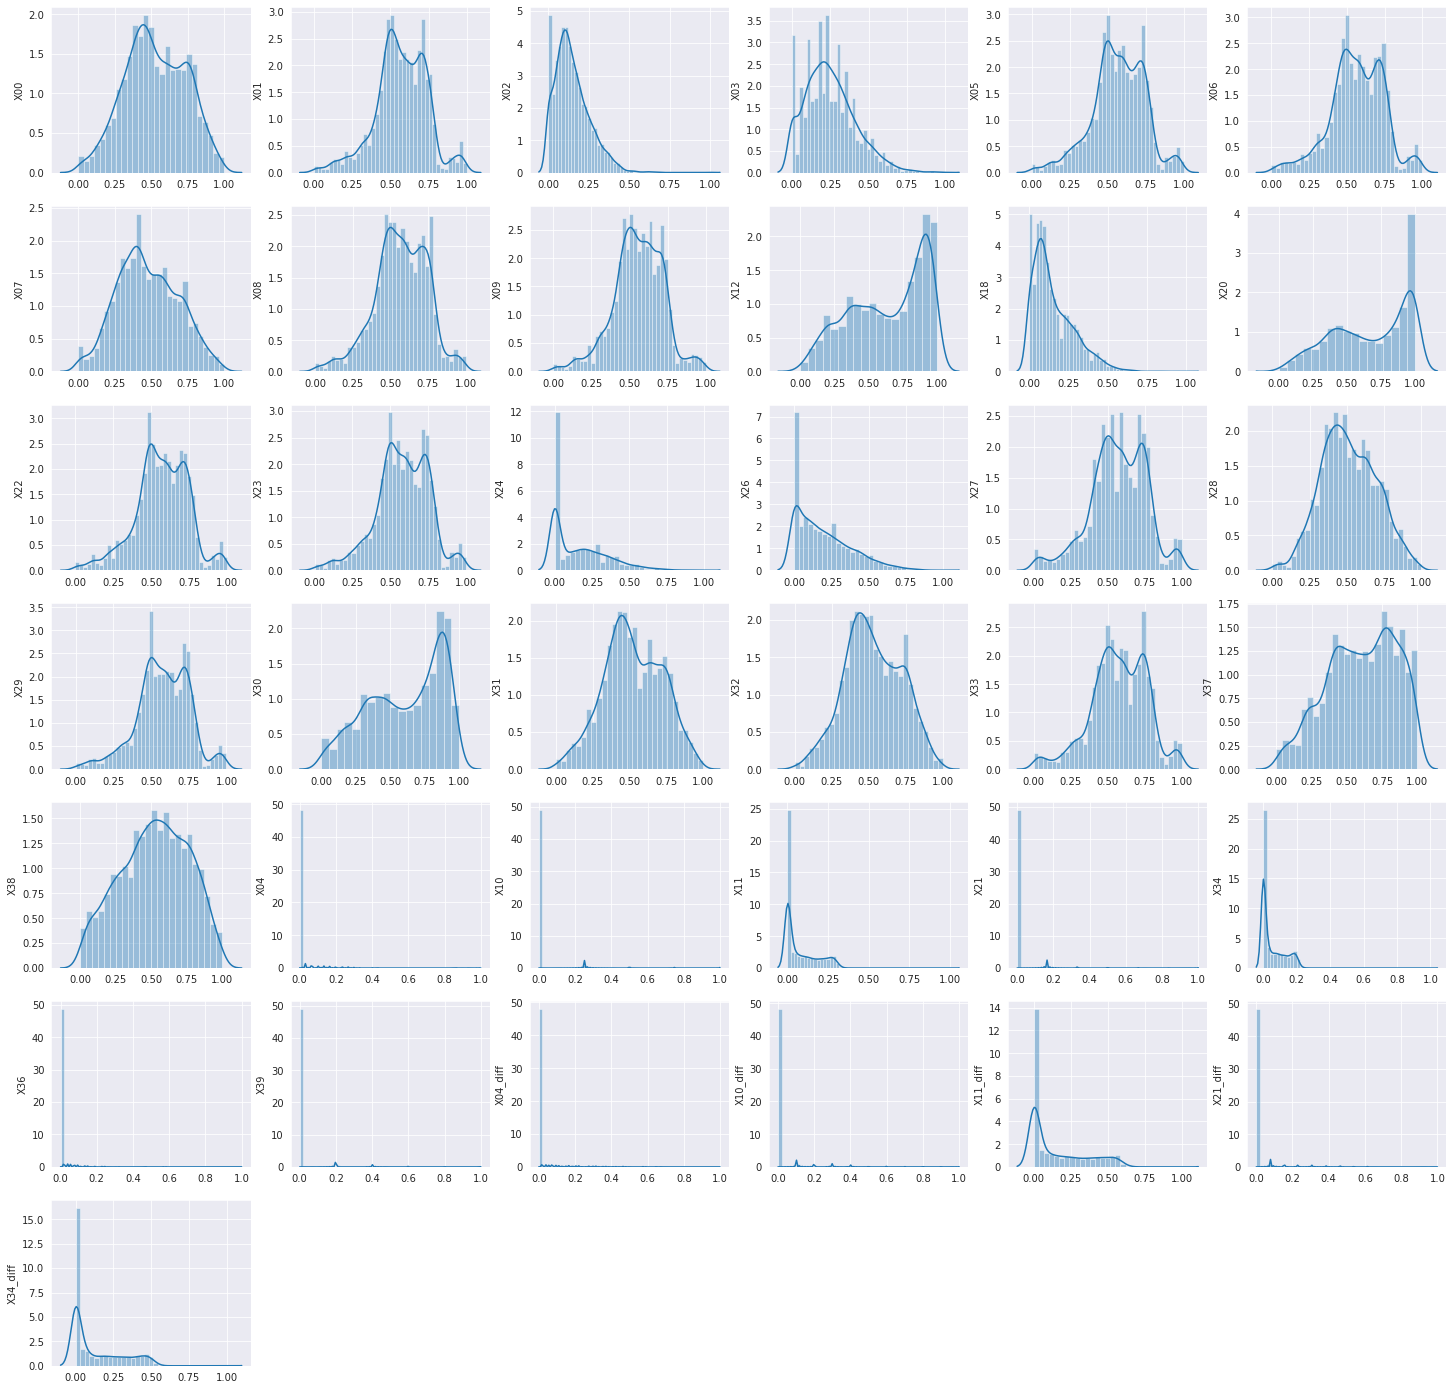

In [6]:
sns.set_style("darkgrid")
plt.figure(figsize=(25,25))
for i, col in enumerate(train1.columns[1:38]):
    plt.subplot(7,6,i+1)
    sns.distplot(train1[col])
    plt.title("")
    plt.xlabel("")
    plt.ylabel(col)

In [92]:
import keras
import tensorflow as tf

from keras.models import Sequential
from keras import backend as K
from keras.utils import get_custom_objects
from keras.layers import Dense, Dropout, LSTM, Input, Activation, BatchNormalization
from keras import optimizers

train_reshaped = np.expand_dims(train2 ,axis=1)
class mish(Activation):
    def __init__(self, activation, **kwargs):
        super(mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def Mish(x):
    return x*K.tanh(K.softplus(x))

def mse_AIFrenz(y_true, y_pred):
    diff = abs(y_true - y_pred)
    less_then_one = np.where(diff < 1, 0, diff)
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    try:
        score = np.average(np.average(less_then_one ** 2, axis = 0))
    except ValueError:
        score = mean_squared_error(y_true, y_pred)
    return score

def mse_keras(y_true, y_pred):
    score = tf.py_function(func=mse_AIFrenz, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

get_custom_objects().update({'mish': mish(Mish)}) 

model = Sequential()
model.add(LSTM(250, return_sequences= True,input_shape=train_reshaped.shape[-2:]))
model.add(LSTM(100, return_sequences= False,activation='linear',))
model.add(Dense(100,activation='linear'))
model.add(Dense(50,activation='linear'))
model.add(Dense(18,activation='linear'))
adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse', metrics=[mse_keras])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1, 250)            309000    
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               140400    
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_15 (Dense)             (None, 18)                918       
Total params: 465,468
Trainable params: 465,468
Non-trainable params: 0
_________________________________________________________________


In [93]:
epochs = 100
batch_size = 64
epoch_size = train2.shape[0]

lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e-3, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)
model.fit(train_reshaped, train_y ,batch_size=64, epochs=100, shuffle=False,callbacks=[lr_finder])

Epoch 1/100
 704/4320 [===>..........................] - ETA: 12s - loss: 633.6823 - mse_keras: 633.6823

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.282554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


4320/4320 [==============================] - 3s 778us/step - loss: 599.4312 - mse_keras: 599.4312
Epoch 2/100
4320/4320 [==============================] - 1s 267us/step - loss: 592.8527 - mse_keras: 592.8527
Epoch 3/100
4320/4320 [==============================] - 1s 275us/step - loss: 576.3267 - mse_keras: 576.3267
Epoch 4/100
4320/4320 [==============================] - 1s 272us/step - loss: 519.6302 - mse_keras: 519.6302
Epoch 5/100
4320/4320 [==============================] - 1s 262us/step - loss: 334.5594 - mse_keras: 334.5566
Epoch 6/100
4320/4320 [==============================] - 1s 267us/step - loss: 116.3407 - mse_keras: 116.3178
Epoch 7/100
4320/4320 [==============================] - 1s 277us/step - loss: 72.8614 - mse_keras: 72.8297
Epoch 8/100
4320/4320 [==============================] - 1s 272us/step - loss: 65.1428 - mse_keras: 65.1136
Epoch 9/100
4320/4320 [==============================] - 1s 291us/step - loss: 63.6978 - mse_keras: 63.6695
Epoch 10/100
4320/4320 [====

In [14]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt
plt.figure(figsize = (13,8))
class LRFinder(Callback):
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        self.total_iterations = steps_per_epoch * epochs
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')

<Figure size 936x576 with 0 Axes>

In [27]:
nadam = optimizers.Nadam(lr=0.001)
model.compile(optimizer=nadam, loss='mse')
early_stop = keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

ckpt_dir = '/gdrive/My Drive/ckpt1'
ckpt_path = ckpt_dir + '/model3_{epoch:02d}_valloss{val_loss:.2f}.hdf5'
ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
epochs = 50
batch_size = 288
epoch_size = train2.shape[0]

lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e-3, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)

model.fit(train_reshaped, train_y,batch_size=288, epochs=50,callbacks=[early_stop],shuffle=False)

Epoch 1/50
4320/4320 [==============================] - 5s 1ms/step - loss: 17.9509
Epoch 2/50
2880/4320 [===================>..........] - ETA: 0s - loss: 14.7107

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


4320/4320 [==============================] - 0s 66us/step - loss: 15.0886
Epoch 3/50
4320/4320 [==============================] - 0s 62us/step - loss: 15.8460
Epoch 4/50
4320/4320 [==============================] - 0s 65us/step - loss: 15.6887
Epoch 5/50
4320/4320 [==============================] - 0s 62us/step - loss: 15.3895
Epoch 6/50
4320/4320 [==============================] - 0s 64us/step - loss: 15.1411
Epoch 7/50
4320/4320 [==============================] - 0s 63us/step - loss: 14.9759
Epoch 8/50
4320/4320 [==============================] - 0s 63us/step - loss: 14.8371
Epoch 9/50
4320/4320 [==============================] - 0s 64us/step - loss: 15.0508
Epoch 10/50
4320/4320 [==============================] - 0s 65us/step - loss: 14.5393
Epoch 11/50
4320/4320 [==============================] - 0s 63us/step - loss: 14.9209
Epoch 12/50
4320/4320 [==============================] - 0s 63us/step - loss: 14.8338
Epoch 13/50
4320/4320 [==============================] - 0s 62us/step - l

In [0]:
model.load_weights('/gdrive/My Drive/ckpt1/model2_11_valloss2.41.hdf5')
model.fit(train_reshaped, train_y,batch_size=12, epochs=30,validation_split=0.1,callbacks=[ckpt, lr_finder,early_stop],shuffle=False)

Train on 3888 samples, validate on 432 samples
Epoch 1/30
3888/3888 [==============================] - 5s 1ms/step - loss: 4.5895 - val_loss: 2.5602
Epoch 2/30
3888/3888 [==============================] - 5s 1ms/step - loss: 4.2775 - val_loss: 2.6647
Epoch 3/30
3888/3888 [==============================] - 5s 1ms/step - loss: 4.0231 - val_loss: 2.7290
Epoch 4/30
3888/3888 [==============================] - 5s 1ms/step - loss: 3.9084 - val_loss: 2.8665
Epoch 5/30
3888/3888 [==============================] - 5s 1ms/step - loss: 3.8816 - val_loss: 3.0963
Epoch 6/30
3888/3888 [==============================] - 5s 1ms/step - loss: 4.0043 - val_loss: 3.4665
Epoch 7/30
3888/3888 [==============================] - 5s 1ms/step - loss: 4.0046 - val_loss: 3.6026
Epoch 8/30
3888/3888 [==============================] - 5s 1ms/step - loss: 4.0821 - val_loss: 3.8406
Epoch 9/30
3888/3888 [==============================] - 5s 1ms/step - loss: 4.1517 - val_loss: 4.1519
Epoch 10/30
3888/3888 [============

In [0]:
model.load_weights('/gdrive/My Drive/ckpt1/model2_11_valloss2.41.hdf5')
y017 = model.predict(np.expand_dims(train3,axis=1))
y017 = pd.DataFrame(y017,columns=y_col)
y017.head()

,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17
0,19.432991,19.817572,19.844597,23.385502,23.434603,19.432663,17.963848,18.531515,18.851442,17.063595,17.707447,18.099831,18.288107,17.360958,17.418745,17.268051,17.941160,17.531805
1,19.309128,19.661301,19.687712,23.260513,23.307964,19.337559,17.874836,18.445072,18.754503,16.961145,17.602913,17.972799,18.205095,17.279737,17.326323,17.188198,17.850767,17.449474
2,19.371439,19.655750,19.684170,23.378521,23.423359,19.235029,17.779739,18.354765,18.640989,16.842039,17.464138,17.775673,18.066933,17.238667,17.304928,17.125481,17.722244,17.361906
3,19.494471,19.807470,19.837063,23.503359,23.549723,19.328089,17.865574,18.438482,18.736059,16.939383,17.563517,17.895590,18.147350,17.319933,17.396156,17.204475,17.810612,17.439808
4,19.471027,19.769724,19.799324,23.485115,23.530869,19.293959,17.834270,18.408033,18.700731,16.903088,17.525211,17.845913,18.112442,17.296026,17.372005,17.178665,17.775019,17.411589


In [28]:
y_train = pd.concat([train3,train18],axis=1,sort=False)
y_train.head()

,id,X00,X01,X02,X03,X05,X06,X07,X08,X09,X12,X18,X20,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X37,X38,X04,X10,X11,X21,X34,X36,X39,X04_diff,X10_diff,X11_diff,X21_diff,X34_diff,X36_diff,X39_diff,X13_si,X15_si,X17_si,X25_si,X35_si,X13_cos,X15_cos,X17_cos,X25_cos,X35_cos,minute_sin,minute_cos,hour_sin,hour_cos,minute_sin,minute_cos,hour_sin,hour_cos,Y18
0,4320,0.486726,0.522614,0.088235,0.379310,0.535715,0.512953,0.436019,0.519802,0.511522,0.942331,0.056180,0.860614,0.533678,0.54592,0.183333,0.000000,0.521978,0.467249,0.538859,0.879699,0.456835,0.481752,0.530386,0.828144,0.776333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300706,-0.733730,0.0,-0.976296,-0.113203,-0.953717,0.679441,1.0,-0.216440,0.993572,0.000000,1.000000,0.0,1.0,0.000000,1.000000,0.0,1.0,20.5
1,4321,0.473451,0.517587,0.186275,0.379310,0.535715,0.512953,0.426540,0.519802,0.511522,0.948466,0.011236,0.888747,0.533678,0.54592,0.066667,0.014706,0.521978,0.454148,0.538859,0.864662,0.446043,0.492701,0.530386,0.833126,0.797139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.676876,-0.778243,0.0,-0.991445,-0.837719,0.736097,0.627963,1.0,-0.130526,0.546102,0.043619,0.999048,0.0,1.0,0.043619,0.999048,0.0,1.0,20.5
2,4322,0.477876,0.517587,0.196078,0.241379,0.540816,0.518133,0.421801,0.524754,0.511522,0.947239,0.000000,0.888747,0.538862,0.54592,0.016667,0.000000,0.521978,0.454148,0.538859,0.855890,0.435252,0.500000,0.530386,0.839352,0.806242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.912834,0.0,-0.284015,-0.795474,1.000000,0.408331,1.0,0.958820,0.605988,0.087156,0.996195,0.0,1.0,0.087156,0.996195,0.0,1.0,20.5
3,4323,0.482301,0.522614,0.176471,0.258621,0.545920,0.518133,0.421801,0.524754,0.516129,0.948466,0.000000,0.896420,0.544042,0.54592,0.000000,0.000000,0.527471,0.449782,0.538859,0.848371,0.438849,0.503650,0.535913,0.839352,0.816645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.886204,0.0,0.000000,-0.699663,1.000000,0.463296,1.0,1.000000,0.714473,0.130526,0.991445,0.0,1.0,0.130526,0.991445,0.0,1.0,20.5
4,4324,0.482301,0.527638,0.137255,0.241379,0.545920,0.518133,0.421801,0.519802,0.520736,0.950920,0.000000,0.895141,0.544042,0.55102,0.000000,0.000000,0.527471,0.445415,0.544042,0.845865,0.435252,0.510949,0.535913,0.839352,0.819246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.991671,0.0,0.000000,-0.626604,1.000000,0.128795,1.0,1.000000,0.779338,0.173648,0.984808,0.0,1.0,0.173648,0.984808,0.0,1.0,20.5


In [33]:
def high_corr(df, col, ratio):
    Y_corr = df.corr()
    Y_high = Y_corr.loc[:,(Y_corr[col]> ratio)|(Y_corr[col] < -ratio)].columns
    return Y_high
Y_high = high_corr(y_train, "Y18", 0.5)
print(Y_high)


Index(['X00', 'X06', 'X07', 'X08', 'X09', 'X12', 'X18', 'X20', 'X23', 'X24',
       'X28', 'X30', 'X31', 'X32', 'X37', 'X38', 'X11', 'X34', 'X11_diff',
       'X34_diff', 'minute_cos', 'hour_cos', 'minute_cos', 'hour_cos', 'Y18'],
      dtype='object')


In [0]:
y_train = pd.concat([train3,y017],axis=1,sort=False)

In [0]:
model1 = Sequential()
model1.add(LSTM(100, return_sequences=False, input_shape=(1,y_train.shape[1]),activation='mish' ))
# model.add(LSTM(50, return_sequences= False,activation='relu',))
model1.add(Dense(50,activation='mish'))
# model1.add(BatchNormalization())
model1.add(Dense(30,activation='mish'))
model1.add(Dense(1,activation='linear'))
adam = optimizers.Adam(lr=0.0005)

model1.compile(optimizer=adam, loss='mse')
model1.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 100)               64400     
_________________________________________________________________
dense_43 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_44 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 31        
Total params: 71,011
Trainable params: 71,011
Non-trainable params: 0
_________________________________________________________________


In [0]:
ckpt_dir = '/gdrive/My Drive/ckpt1'
ckpt_path = ckpt_dir + '/model3_{epoch:02d}_valloss{loss:.2f}.hdf5'
ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='var_loss', verbose=0, save_best_only=True, mode='min')
epochs = 100
batch_size = 24
epoch_size = y017.shape[0]

early_stop = keras.callbacks.EarlyStopping(patience=20, monitor='loss')
lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e-3, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)
model1.fit(np.expand_dims(y_train,axis=1),train18,batch_size=24,validation_split=0.1, epochs=100,callbacks=[early_stop, lr_finder])

Train on 388 samples, validate on 44 samples
Epoch 1/100
388/388 [==============================] - 0s 490us/step - loss: 3.8476 - val_loss: 0.2090
Epoch 2/100
388/388 [==============================] - 0s 528us/step - loss: 3.7261 - val_loss: 0.6369
Epoch 3/100
388/388 [==============================] - 0s 445us/step - loss: 3.6694 - val_loss: 0.4914
Epoch 4/100
388/388 [==============================] - 0s 442us/step - loss: 3.6266 - val_loss: 0.9799
Epoch 5/100
388/388 [==============================] - 0s 449us/step - loss: 3.7852 - val_loss: 0.8712
Epoch 6/100
388/388 [==============================] - 0s 493us/step - loss: 3.7105 - val_loss: 0.5218
Epoch 7/100
388/388 [==============================] - 0s 479us/step - loss: 3.8138 - val_loss: 1.6447
Epoch 8/100
388/388 [==============================] - 0s 545us/step - loss: 3.7524 - val_loss: 0.7088
Epoch 9/100
388/388 [==============================] - 0s 468us/step - loss: 3.9934 - val_loss: 0.2205
Epoch 10/100
388/388 [======

In [0]:
ckpt_dir = '/gdrive/My Drive/ckpt2'
ckpt_path = ckpt_dir + '/model1_{epoch:02d}_valloss{loss:.2f}.hdf5'
ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='var_loss', verbose=0, save_best_only=True, mode='min')
epochs = 100
batch_size = 12
epoch_size = y017.shape[0]

early_stop = keras.callbacks.EarlyStopping(patience=20, monitor='loss')
lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e-3, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)
model1.load_weights('/gdrive/My Drive/ckpt2/model1_81_valloss1.54.hdf5')
model1.fit(np.expand_dims(y017,axis=1),train18,batch_size=12,validation_split=0.05, epochs=100,callbacks=[lr_finder,early_stop])

Train on 388 samples, validate on 44 samples
Epoch 1/200
388/388 [==============================] - 0s 957us/step - loss: 1.7352 - val_loss: 0.9535
Epoch 2/200
228/388 [================>.............] - ETA: 0s - loss: 1.6028

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with var_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


388/388 [==============================] - 0s 849us/step - loss: 1.5495 - val_loss: 2.0786
Epoch 3/200
388/388 [==============================] - 0s 848us/step - loss: 1.6509 - val_loss: 1.6663
Epoch 4/200
388/388 [==============================] - 0s 997us/step - loss: 1.7797 - val_loss: 1.5591
Epoch 5/200
388/388 [==============================] - 0s 914us/step - loss: 1.5938 - val_loss: 0.9621
Epoch 6/200
388/388 [==============================] - 0s 910us/step - loss: 1.6004 - val_loss: 1.3707
Epoch 7/200
388/388 [==============================] - 0s 930us/step - loss: 1.5498 - val_loss: 1.1046
Epoch 8/200
388/388 [==============================] - 0s 861us/step - loss: 1.5083 - val_loss: 1.7379
Epoch 9/200
388/388 [==============================] - 0s 876us/step - loss: 1.5699 - val_loss: 3.0186
Epoch 10/200
388/388 [==============================] - 0s 945us/step - loss: 1.6838 - val_loss: 1.6368
Epoch 11/200
388/388 [==============================] - 0s 863us/step - loss: 1.6639

In [0]:
yt017 = model.predict(np.expand_dims(test,axis=1))

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y18,hour
X00,1.000000,-0.696720,0.440166,0.300344,NaN,-0.730695,-0.701124,0.944908,-0.777789,-0.785817,-0.076724,0.594476,-0.886610,0.173283,-0.021463,0.303033,0.692302,-0.967237,-0.068537,-0.706988,-0.727793,0.778122,0.581917,0.621905,-0.678161,0.924128,-0.694877,-0.884103,0.937889,0.924167,-0.695748,0.612575,0.205820,NaN,-0.943287,-0.902065,0.102556,0.847230,0.538593
X01,-0.696720,1.000000,-0.447365,-0.294557,NaN,0.961756,0.982726,-0.682473,0.972826,0.987940,0.175013,-0.523687,0.621786,-0.118405,-0.264896,-0.349187,-0.493382,0.656779,0.158382,0.965681,0.973770,-0.502816,-0.348428,-0.527947,0.970266,-0.670913,0.975725,0.615949,-0.649316,-0.612120,0.970067,-0.562285,-0.048601,NaN,0.696238,0.642507,-0.093939,-0.469846,-0.368268
X02,0.440166,-0.447365,1.000000,0.206428,NaN,-0.479808,-0.471977,0.435400,-0.483359,-0.456900,0.074002,0.340910,-0.334254,0.085013,0.195446,0.159972,0.363650,-0.424916,0.107573,-0.472819,-0.476762,0.328928,0.274054,0.309952,-0.462472,0.459094,-0.469067,-0.383353,0.351383,0.392272,-0.468204,0.343533,-0.011653,NaN,-0.443812,-0.443446,0.210160,0.346297,0.254406
X03,0.300344,-0.294557,0.206428,1.000000,NaN,-0.299973,-0.318951,0.303423,-0.326369,-0.308741,-0.021169,0.247194,-0.266408,0.059514,0.083216,0.125422,0.235622,-0.284736,0.001721,-0.295444,-0.324300,0.204122,0.200558,0.308729,-0.314707,0.275629,-0.320286,-0.287687,0.280043,0.284122,-0.318467,0.266386,0.012769,NaN,-0.299352,-0.295032,0.035041,0.234911,0.236408
X04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X05,-0.730695,0.961756,-0.479808,-0.299973,NaN,1.000000,0.964957,-0.729163,0.957938,0.954025,0.012442,-0.626618,0.591310,-0.127396,-0.192379,-0.357919,-0.479952,0.647315,-0.020808,0.998932,0.986579,-0.518316,-0.391944,-0.582313,0.972912,-0.772202,0.984826,0.595847,-0.637963,-0.625722,0.974671,-0.639190,-0.015809,NaN,0.728059,0.752784,-0.308303,-0.484977,-0.469972
X06,-0.701124,0.982726,-0.471977,-0.318951,NaN,0.964957,1.000000,-0.695749,0.989530,0.972398,0.153129,-0.511806,0.621290,-0.114372,-0.260130,-0.341382,-0.510769,0.649411,0.117818,0.968341,0.985148,-0.500333,-0.337355,-0.547430,0.982268,-0.685835,0.986983,0.631506,-0.645177,-0.623382,0.981708,-0.546013,-0.004143,NaN,0.712982,0.671160,-0.130987,-0.502424,-0.356921
X07,0.944908,-0.682473,0.435400,0.303423,NaN,-0.729163,-0.695749,1.000000,-0.780651,-0.770639,-0.121321,0.636673,-0.882022,0.140170,-0.062547,0.294954,0.680648,-0.880499,-0.076489,-0.703712,-0.736905,0.780890,0.629398,0.604215,-0.651435,0.946606,-0.699867,-0.910036,0.933640,0.962667,-0.668008,0.652966,0.223357,NaN,-0.983196,-0.907242,0.131228,0.832904,0.559231
X08,-0.777789,0.972826,-0.483359,-0.326369,NaN,0.957938,0.989530,-0.780651,1.000000,0.981654,0.176397,-0.537093,0.707189,-0.118348,-0.222171,-0.347877,-0.575868,0.729979,0.138431,0.956261,0.979003,-0.578109,-0.406942,-0.579734,0.961742,-0.757081,0.973818,0.725394,-0.733466,-0.724026,0.964326,-0.572675,-0.046709,NaN,0.795950,0.735540,-0.107421,-0.592733,-0.390949
X09,-0.785817,0.987940,-0.456900,-0.308741,NaN,0.954025,0.972398,-0.770639,0.981654,1.000000,0.194605,-0.539445,0.727043,-0.131345,-0.224049,-0.354446,-0.573077,0.750071,0.177422,0.952875,0.967838,-0.585660,-0.408832,-0.573357,0.952848,-0.744390,0.962373,0.713069,-0.755199,-0.713077,0.956109,-0.579262,-0.081204,NaN,0.783023,0.714861,-0.064060,-0.575147,-0.399116


In [0]:
# model1.load_weights('/gdrive/My Drive/ckpt2/model2_58_valloss2.75.hdf5')
yt017 = model.predict(np.expand_dims(test1,axis=1))
yt017 = pd.DataFrame(yt017,columns= train_y.columns)
# yt017 = scaler1.transform(yt017)
yt18 = model1.predict(np.expand_dims(yt017[Y_high.tolist()],axis=1))

In [0]:
pd.DataFrame(yt18).describe()

,0
count,11520.000000
mean,27.363480
std,3.933295
min,18.216976
25%,24.663368
50%,27.281628
75%,29.705994
max,43.449173


In [0]:
sample_sub["Y18"] = yt18
sample_sub.to_csv('/gdrive/My Drive/Data/sample3.csv',index=False)

In [0]:
sample2 = yt18

In [0]:
y18.describe()

count    432.000000
mean      26.687500
std        6.286621
min       18.500000
25%       21.000000
50%       25.000000
75%       31.500000
max       41.500000
Name: Y18, dtype: float64

In [90]:
lgb_train = lgb.Dataset(train3, label=train18)

lgb_param = {
    "objective":"regression",
    "metrics":"mse",
    "learning_rate":0.005
}

print("cv start")
cv_result = lgb.cv(
    lgb_param,
    lgb_train,
    num_boost_round=7000,
    nfold=5,
    early_stopping_rounds=10,
    stratified=False,
    verbose_eval=200
)

print("train start")
lgb_model = lgb.train(
    lgb_param,
    lgb_train,
    num_boost_round=len(cv_result["l1-mean"])
)

cv start
[200]	cv_agg's l1: 3.1137 + 0.139033
[400]	cv_agg's l1: 1.83269 + 0.0904644
[600]	cv_agg's l1: 1.13978 + 0.0740503
[800]	cv_agg's l1: 0.785138 + 0.0708553
[1000]	cv_agg's l1: 0.618881 + 0.0646958
[1200]	cv_agg's l1: 0.539878 + 0.0569717
[1400]	cv_agg's l1: 0.502854 + 0.0551442
[1600]	cv_agg's l1: 0.48514 + 0.0571781
[1800]	cv_agg's l1: 0.474372 + 0.0573858
[2000]	cv_agg's l1: 0.467349 + 0.0573714
[2200]	cv_agg's l1: 0.462231 + 0.0586767
[2400]	cv_agg's l1: 0.458227 + 0.0592723
[2600]	cv_agg's l1: 0.454869 + 0.0597212
[2800]	cv_agg's l1: 0.453242 + 0.0603815
[3000]	cv_agg's l1: 0.45102 + 0.0602321
train start


In [0]:
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error
def lgb_cv(num_leaves, learning_rate, n_estimators, reg_alpha, reg_lambda, min_split_gain, min_child_weight,min_child_samples, colsample_bytree, x_data=None, y_data=None, n_splits=5, output='score'):
    score = 0
    kf = KFold(n_splits=n_splits)
    models = []
    for train_index, valid_index in kf.split(x_data):
        x_train, y_train = x_data.iloc[train_index], y_data[train_index]
        x_valid, y_valid = x_data.iloc[valid_index], y_data[valid_index]
        
        model = lgb.LGBMRegressor(
            num_leaves = int(num_leaves), 
            learning_rate = learning_rate, 
            n_estimators = int(n_estimators), 
            reg_alpha = reg_alpha, 
            reg_lambda = reg_lambda,
            min_split_gain= min_split_gain,
            min_child_weight = min_child_weight,
            min_child_samples = int(min_child_samples),
            colsample_bytree = np.clip(colsample_bytree, 0, 1), 
        )
        
        model.fit(x_train, y_train)
        models.append(model)
        
        pred = model.predict(x_valid)
        true = y_valid
        score -= mse_AIFrenz(true, pred)/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [0]:
from functools import partial 
from bayes_opt import BayesianOptimization
func_fixed = partial(lgb_cv, x_data=train2, y_data=train_y["Y16"], n_splits=5, output='score')
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (50, 150),    
        'learning_rate': (0.001, 0.01),  
        'n_estimators': (5000, 7000),                        
        'reg_alpha': (0.0001, 1),       
        'reg_lambda': (0.0001, 1), 
        'min_split_gain' : (0.001, 0.1),
        'min_child_weight' : (0.001, 0.1),
        'min_child_samples' : (10,25),
        'colsample_bytree': (0.85, 1.0),
    }, 
    random_state=4321            
)
lgbBO.maximize(init_points=5, n_iter=20)

|   iter    |  target   | colsam... | learni... | min_ch... | min_ch... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
